In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

In [2]:
tf.__version__

'2.0.0-alpha0'

In [3]:
!python -V

Python 3.7.3


In [4]:
data = pd.read_csv("/home/jagadeesh/DS/FB.csv",parse_dates=['Date'],index_col='Date')

In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


In [6]:
def make_dataset(array,time_steps):

    x = []
    y = []

    for i in range(time_steps,len(array)):
        x.append(array[i-time_steps:i])
        y.append(array[i])
        
    return np.array(x), np.array(y)

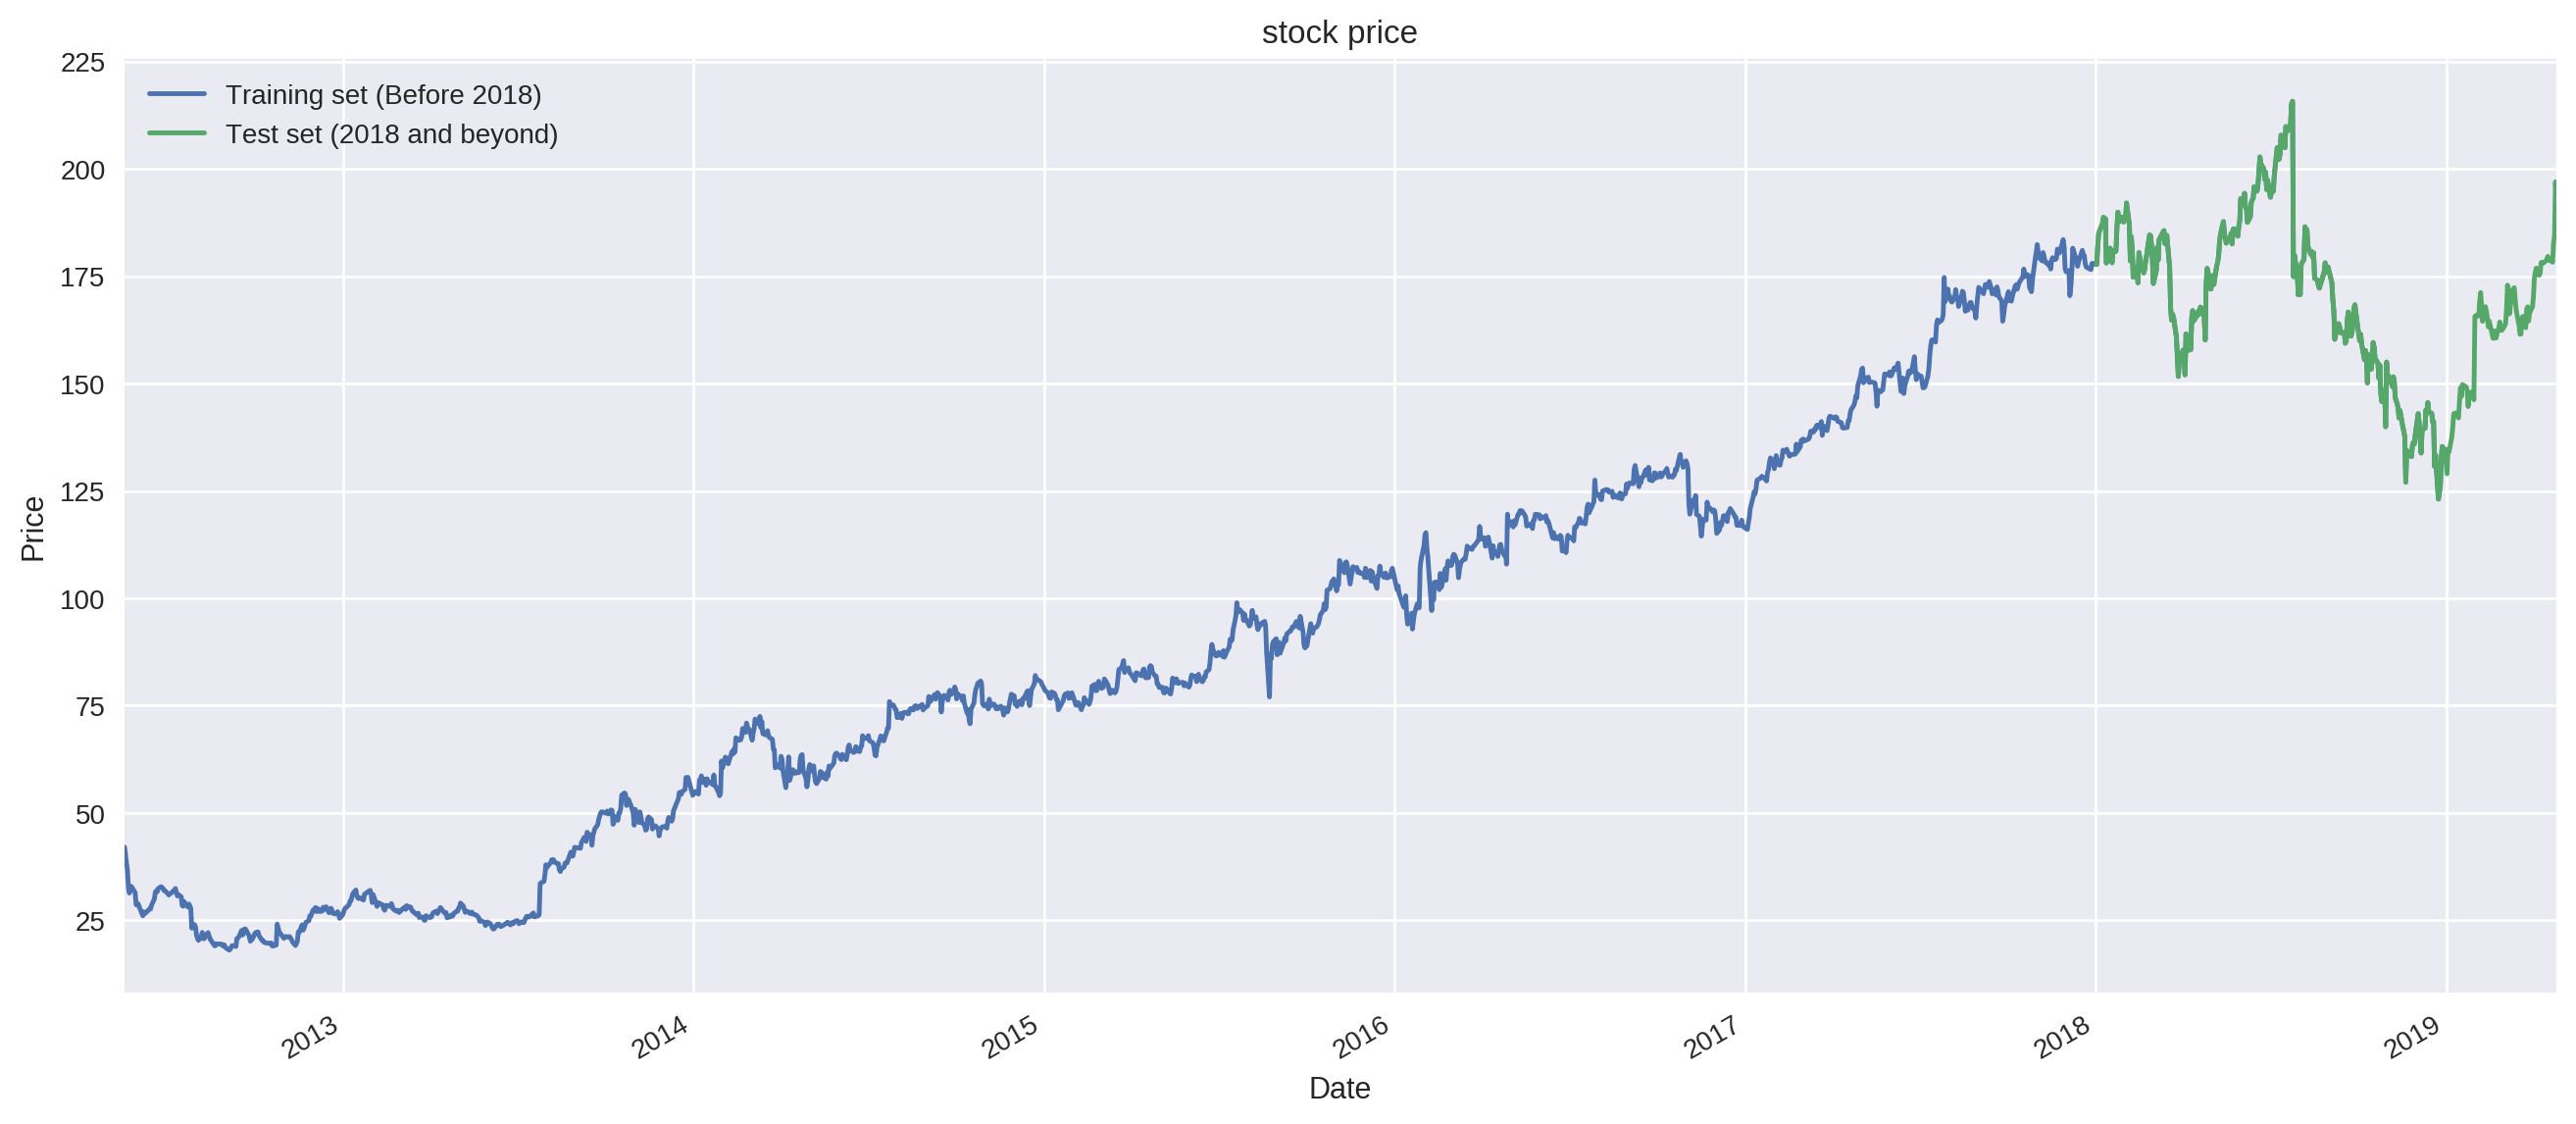

In [7]:
plt.figure(dpi=200,figsize=(16,7))
data["Open"][:'2018'].plot(legend=True)
data["Open"]['2018':].plot(legend=True)
plt.legend(['Training set (Before 2018)','Test set (2018 and beyond)'])
plt.title('stock price')
plt.ylabel("Price")
plt.show()

In [8]:
train = data[:"2018"]["Open"].values


scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train.reshape(-1,1))

trn_x,trn_y = make_dataset(train,60)

## The three dimensions of this input are:

* **Samples**. One sequence is one sample. A batch is comprised of one or more samples.
* **Time Steps**. One time step is one point of observation in the sample.
* **Features**. One feature is one observation at a time step.

In [9]:
trn_x = trn_x.reshape(-1,60,1)

### Model Architecture

* LSTM(50)
* LSTM(50)
* LSTM(50)
* Dense(500)
* Dropout(0.2)
* Dense(1)

In [10]:
model = tf.keras.models.Sequential()

model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50, return_sequences=True))
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50, return_sequences=True))
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50))

model.add(tf.keras.layers.Dense(500))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(1))

early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=15)
model.compile(optimizer='adam', loss='mse', callbacks=[early_stop])

In [11]:
model.fit(trn_x, trn_y, epochs=300)

Epoch 1/300
1605/1605 [==============================] - 2s 1ms/sample - loss: 0.0182
Epoch 2/300
1605/1605 [==============================] - 1s 352us/sample - loss: 0.0011
Epoch 3/300
1605/1605 [==============================] - 1s 357us/sample - loss: 0.0010
Epoch 4/300
1605/1605 [==============================] - 1s 355us/sample - loss: 9.8685e-04
Epoch 5/300
1605/1605 [==============================] - 1s 357us/sample - loss: 9.7642e-04
Epoch 6/300
1605/1605 [==============================] - 1s 355us/sample - loss: 9.6481e-04
Epoch 7/300
1605/1605 [==============================] - 1s 356us/sample - loss: 8.1045e-04
Epoch 8/300
1605/1605 [==============================] - 1s 355us/sample - loss: 0.0011
Epoch 9/300
1605/1605 [==============================] - 1s 356us/sample - loss: 9.5026e-04
Epoch 10/300
1605/1605 [==============================] - 1s 355us/sample - loss: 0.0013
Epoch 11/300
1605/1605 [==============================] - 1s 354us/sample - loss: 8.3144e-04
Epoch 12

1605/1605 [==============================] - 0s 298us/sample - loss: 4.6271e-04
Epoch 90/300
1605/1605 [==============================] - 1s 312us/sample - loss: 2.9996e-04
Epoch 91/300
1605/1605 [==============================] - 1s 365us/sample - loss: 2.7791e-04
Epoch 92/300
1605/1605 [==============================] - 1s 356us/sample - loss: 3.1720e-04
Epoch 93/300
1605/1605 [==============================] - 1s 321us/sample - loss: 3.9397e-04
Epoch 94/300
1605/1605 [==============================] - 1s 320us/sample - loss: 4.0993e-04
Epoch 95/300
1605/1605 [==============================] - 1s 323us/sample - loss: 3.4917e-04
Epoch 96/300
1605/1605 [==============================] - 1s 323us/sample - loss: 2.9020e-04
Epoch 97/300
1605/1605 [==============================] - 1s 326us/sample - loss: 3.2219e-04
Epoch 98/300
1605/1605 [==============================] - 1s 368us/sample - loss: 2.6722e-04
Epoch 99/300
1605/1605 [==============================] - 1s 371us/sample - loss: 3

1605/1605 [==============================] - 0s 268us/sample - loss: 2.4790e-04
Epoch 177/300
1605/1605 [==============================] - 0s 265us/sample - loss: 2.8612e-04
Epoch 178/300
1605/1605 [==============================] - 0s 300us/sample - loss: 2.3760e-04
Epoch 179/300
1605/1605 [==============================] - 1s 396us/sample - loss: 3.0512e-04
Epoch 180/300
1605/1605 [==============================] - 1s 380us/sample - loss: 2.6481e-04
Epoch 181/300
1605/1605 [==============================] - 1s 411us/sample - loss: 2.5716e-04
Epoch 182/300
1605/1605 [==============================] - 0s 299us/sample - loss: 2.7993e-04
Epoch 183/300
1605/1605 [==============================] - 1s 359us/sample - loss: 3.2462e-04
Epoch 184/300
1605/1605 [==============================] - 0s 276us/sample - loss: 3.0195e-04
Epoch 185/300
1605/1605 [==============================] - 0s 283us/sample - loss: 2.6103e-04
Epoch 186/300
1605/1605 [==============================] - 0s 269us/sample

1605/1605 [==============================] - 0s 290us/sample - loss: 2.1838e-04
Epoch 264/300
1605/1605 [==============================] - 0s 304us/sample - loss: 2.5060e-04
Epoch 265/300
1605/1605 [==============================] - 0s 296us/sample - loss: 2.4556e-04
Epoch 266/300
1605/1605 [==============================] - 0s 292us/sample - loss: 2.2241e-04
Epoch 267/300
1605/1605 [==============================] - 0s 289us/sample - loss: 2.4912e-04
Epoch 268/300
1605/1605 [==============================] - 0s 296us/sample - loss: 2.2772e-04
Epoch 269/300
1605/1605 [==============================] - 0s 293us/sample - loss: 2.1677e-04
Epoch 270/300
1605/1605 [==============================] - 0s 296us/sample - loss: 2.9989e-04
Epoch 271/300
1605/1605 [==============================] - 0s 294us/sample - loss: 2.7232e-04
Epoch 272/300
1605/1605 [==============================] - 0s 293us/sample - loss: 2.2618e-04
Epoch 273/300
1605/1605 [==============================] - 0s 295us/sample

## Validation

* Test our model on whole data including test set(2018 and beyond)

In [12]:
total = data['Open'].values
total_scaled = scaler.transform(total.reshape(-1,1))

total_x,total_y = make_dataset(total_scaled,60)

In [13]:
predicted = model.predict(total_x)
predicted = scaler.inverse_transform(predicted)

In [14]:
#make a dataset with real and predicted values.

infered = pd.DataFrame(data['Open'].iloc[60:])
infered['Open_Predicted'] = predicted

In [15]:
infered.tail()

,Open,Open_Predicted
Date,,
2019-04-22,178.250000,176.418427
2019-04-23,182.740005,175.981537
2019-04-24,184.490005,179.664505
2019-04-25,196.979996,181.576477
2019-04-26,192.500000,192.015793


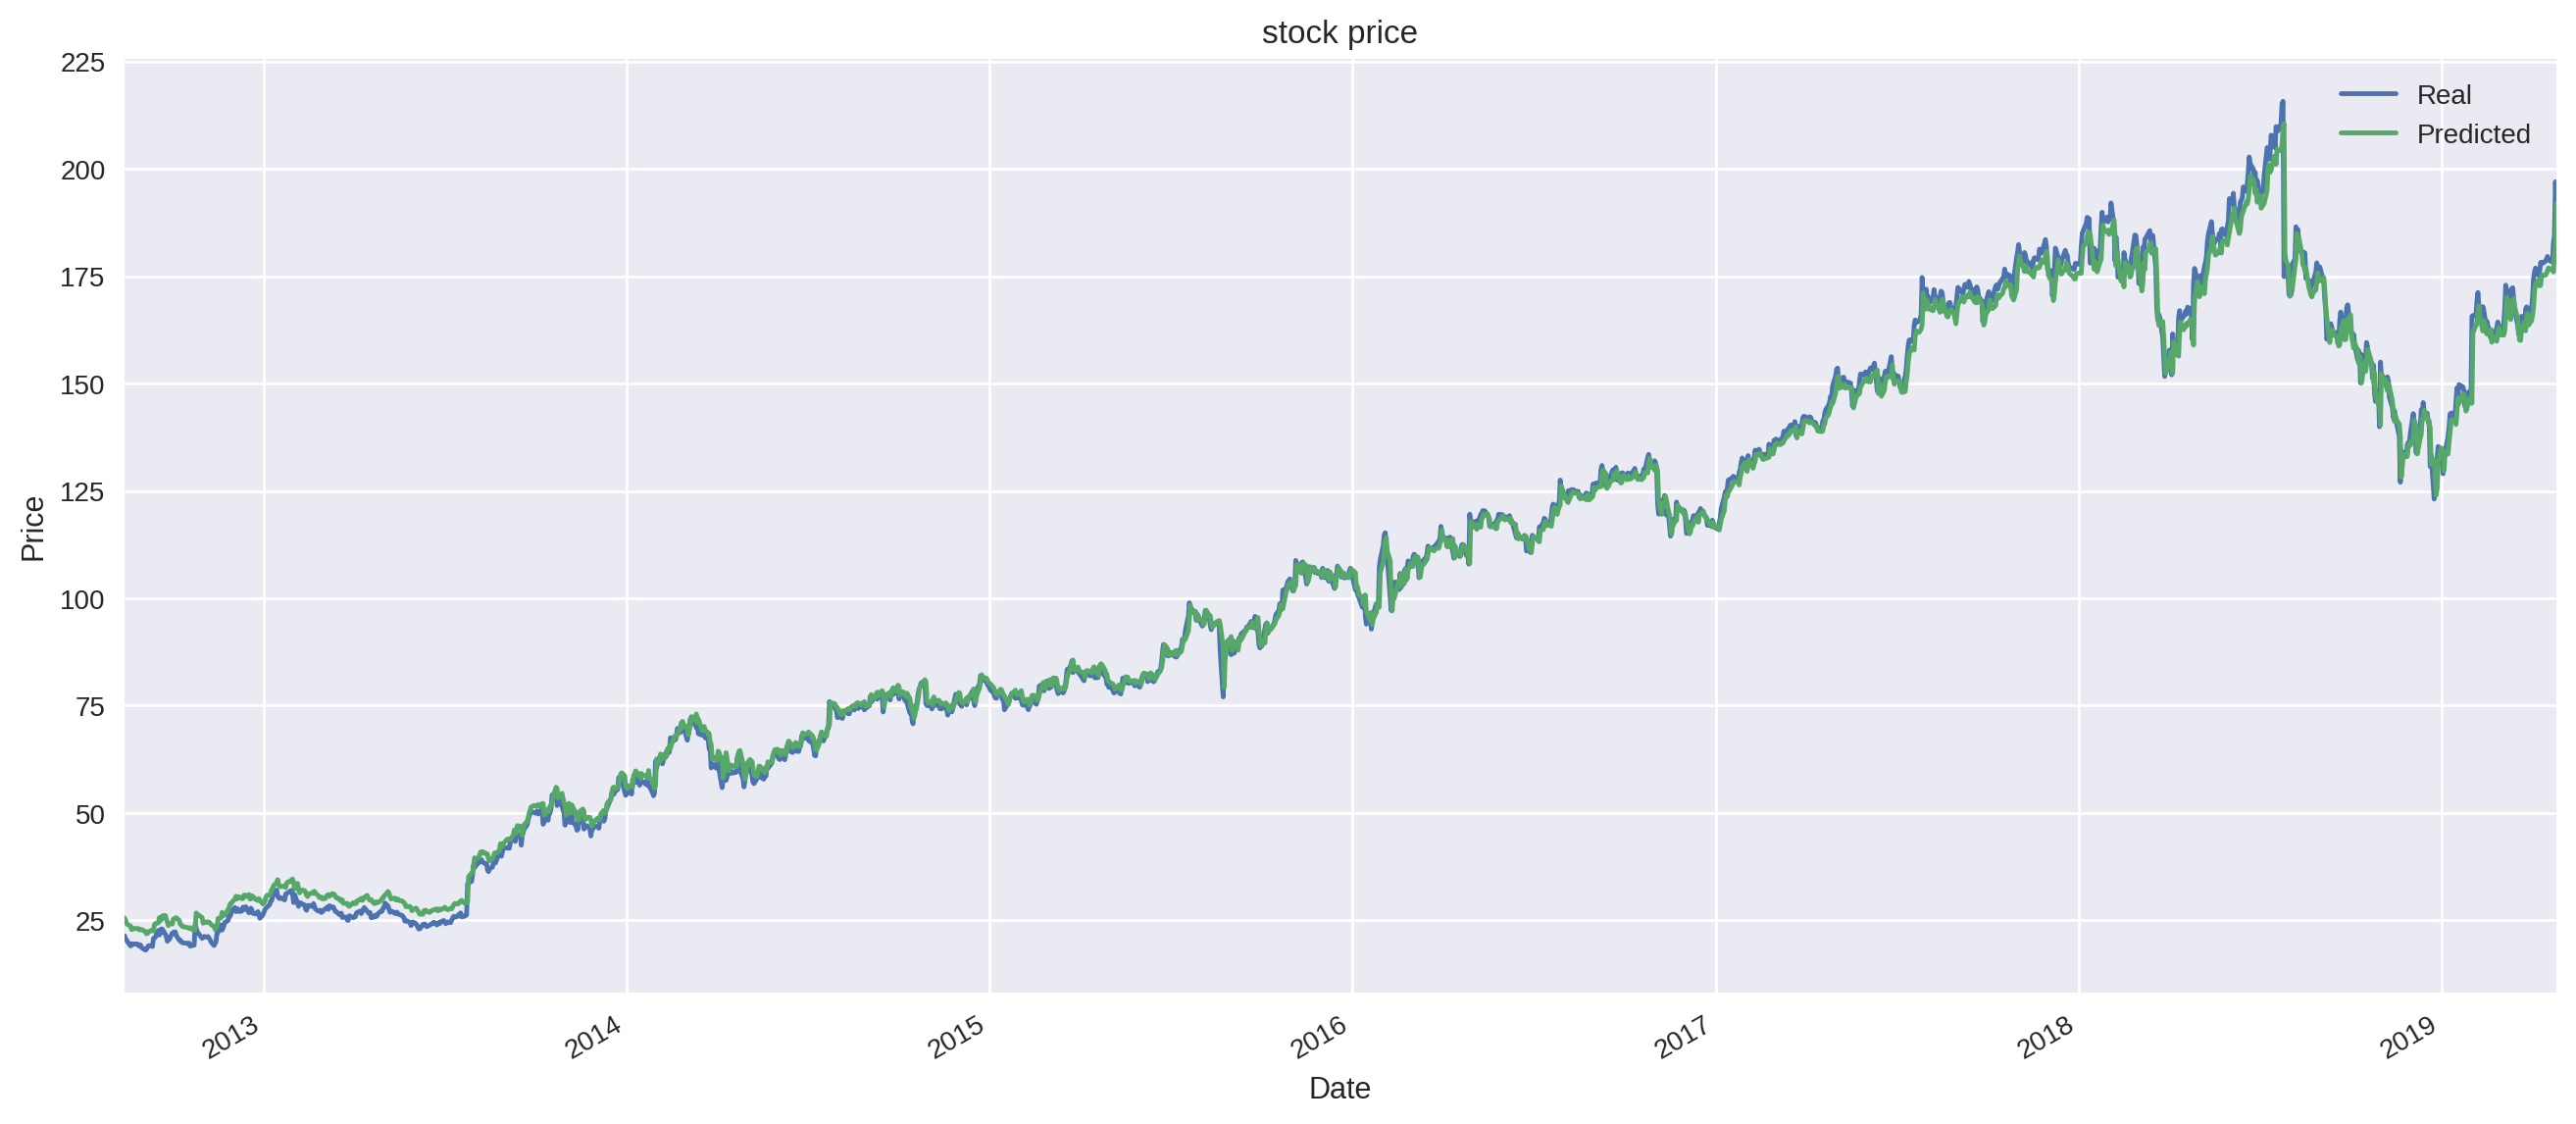

In [16]:
plt.figure(dpi=200,figsize=(16,7))
infered["Open"].plot(legend=True)
infered["Open_Predicted"].plot(legend=True)
plt.legend(['Real','Predicted'])
plt.title('stock price')
plt.ylabel("Price")
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(data['Open'].iloc[60:].values,predicted)
print("RMSE:", np.sqrt(mse))

RMSE: 2.922118107958959


## Predicting Tomorrow

* Take the last prediction value(i.e *predicted[-1]*) from our predictions and add it to the last array of total_x.
* Exclude first timestep.
* Predict.

In [18]:
#array --> List
today = total_x[-1].reshape(-1).tolist()

# scaling last price
last_price = scaler.transform(infered['Open_Predicted'][-1].reshape(-1, 1))

# adding last price to list.
today.append(last_price[0])

# Exclude first(0th index) element
today = today[1:]

#reshape
today = np.array(today).reshape(-1,60,1)

#predict!
tomorrow = model.predict(today)

#inverse transform.
tomorrow = scaler.inverse_transform(tomorrow)[0]

#print it out!
print(tomorrow)

[189.14024]


### Open stock price of Facebook(FB) on next trading day (29-04-2019)
![](https://i.imgur.com/yjFu6Hp.png)